In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
import tqdm
import librosa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import math

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

In [2]:
label = 0
genre = '/Users/urmithakkar/Downloads/Data 3/genres_original'
print(genre)
genrelabel = {}

for folder in os.listdir(genre):
    if folder =='.DS_Store':
      continue
    genrelabel[folder] = label
    label = label+1

/Users/urmithakkar/Downloads/Data 3/genres_original


In [3]:
genrelabel.keys()

dict_keys(['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz'])

In [4]:
rate = 660000
X = []
y = []

for folder in os.listdir(genre):
    if folder =='.DS_Store':
      continue
    for files in tqdm.tqdm(os.listdir(genre+'/'+folder)):
        if files =='.DS_Store':
            continue
        data, sr = librosa.load(genre+'/'+folder+'/'+files)
        data, _ = librosa.effects.trim(data)
        #data = data[:rate]
        X.append(data)
        y.append(genrelabel[folder])

100%|██████████| 100/100 [00:00<00:00, 141.67it/s]


In [5]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [6]:
""" Calculating amplitude envelope """

FRAME_SIZE = 1024
HOP_LENGTH = 512

def amplitude_envelope(signal, frame_size, hop_length):
    amplitude_envelope = [] #This list takes the maximum amplitude value calculated across all the samples in that frame
    
    # calculate amplitude envelope for each frame
    for i in range(0, len(signal), hop_length): #Jumps to each iteration by hop length.
        amplitude_envelope_current_frame = max(signal[i:i+frame_size]) # Slicing the signal considering only the samples for a given frame
        amplitude_envelope.append(amplitude_envelope_current_frame)
    
    return np.array(amplitude_envelope)

In [7]:
"""Band energy ratio """

def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    
    
    frequency_range = sample_rate / 2   #It is the frequency range that we want to capture in the spectogram
    frequency_delta_per_bin = frequency_range / num_frequency_bins   #The delta frequency between two adjacent bins means when we move from one bin to the other, how much do we move in the continous frequency.
    
    """Now, we need to map the continuous frequency to the closest frequency bin. But, (split_frequency / frequency_delta_per_bin) will give us a float value and the frequency bins that we have are discrete. 
    Therefore, we have to convert the float values to integers using numpy floor function"""
    
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)



In [8]:
# Let's calculate the band energy ratio with a given split frequency

"""
Band energy ratio is (the sum of power in lower frequencies) / (sum of the power of higher frequencies)
The split frequency gives us the threshold. All the frequencies above the threshold are higher frequencies and 
all the frequencies below the threshold are lower frequencies.

"""

def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram 
    power_spectrogram = np.abs(spectrogram) ** 2  #Squaring the amplitude spectrogram
    
    """In order to calculate the band energy at each frame, we need to iterate through the power spctograme. But, if we see the shape of the power spctograme, 
    we see that first there is a frequency dimension and second is the time dimension. So, we need to inverse the dimensions as we want the time dimension first(number of frames) as the first dimension. """
    
    power_spectrogram = power_spectrogram.T #inverse the dimensions as we want the time dimension first and then the frequency dimension. 
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)  #List of band energy ratio for each frame.
    
    return np.array(band_energy_ratio, dtype = float)


In [9]:

def getXy(X,y,sr, scale_audio=False, onlySingleDigit=False):
    X1,y1 =[],[]
    i=0
    list_of_features=[]
    
    for file in range(0,len(X)):
        features=[]
        

        FRAME_SIZE = 1024
        HOP_LENGTH = 512

        audio = np.array(X[i])
        yi=y[i]
        i=i+1
        sample_rate = sr 


        mfccs_features = librosa.feature.mfcc(audio, sr=sample_rate, n_mfcc=13)
        mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

        #spectrogram = extract_spectrogram(audio)
        #print(spectrogram)

        stft_scale = np.abs(librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH))
        #Y_scale = np.abs(spectrogram_scale) ** 2
        #print(spectrogram.shape)
        #spectrogram = np.abs(S_scale) ** 2

        spectralroll_off = librosa.feature.spectral_rolloff(audio,sample_rate)
        
        chroma_feature = librosa.feature.chroma_stft(audio,sample_rate)
        
        tempo = librosa.beat.tempo(audio,sample_rate)
        
        #h_p_components = librosa.effects.hpss(audio)

        
        amplitude_env = amplitude_envelope(audio, FRAME_SIZE, HOP_LENGTH)

        root_mean_square_energy = librosa.feature.rms(audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)  #Root-mean-squared energy

        zero_crossing_rate = librosa.feature.zero_crossing_rate(audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]   #Zero-crossing rate with Librosa

        #filter_banks = librosa.filters.mel(sample_rate, n_fft=2048, n_mels=10)   #Mel filter banks

        mel_spectrogram = librosa.feature.melspectrogram(audio, sample_rate, n_fft=2048, hop_length = HOP_LENGTH, n_mels=10) #Extracting Mel Spectrogram

        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram) ##Extracting Log Mel Spectrogram

        #split_frequency_bin = calculate_split_frequency_bin(2000, sample_rate, FRAME_SIZE)

        #Band_energy_ratio = band_energy_ratio(stft_scale, 2000, sample_rate) #band energy ratio

        spectral_centroid = librosa.feature.spectral_centroid(audio, sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0] #Spectral Centroid

        bandwidth = librosa.feature.spectral_bandwidth(audio, sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]  #Spectral Bandwidth
        
        fs = None # if None, fs would be 22050
            #x, fs = librosa.load(file,sr=fs)
        if scale_audio: audio = audio/np.max(np.abs(audio))
        f0, voiced_flag = getPitch(audio,sample_rate,winLen=0.02)
        power = np.sum(audio**2)/len(audio)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)    
    
        features.append(np.mean(mfccs_scaled_features))
        features.append(np.mean(spectralroll_off))
        features.append(np.mean(chroma_feature))
        features.append(np.mean(tempo))
        #features.append(np.mean(h_p_components))
        
        
        
        features.append(np.mean(amplitude_env))
        features.append(np.mean(root_mean_square_energy))
        features.append(np.mean(zero_crossing_rate))
        features.append(np.mean(log_mel_spectrogram))
        
        #features.append(np.mean(Band_energy_ratio))
        features.append(power)
        features.append(pitch_mean)
        features.append(pitch_std)
        features.append(voiced_fr)
        features.append(np.mean(spectral_centroid))
        features.append(np.mean(bandwidth))
    
        list_of_features.append(features)


        y1.append(yi)
    X1 = list_of_features
    #print(len(X1))

    return np.array(X1),np.array(y1)

In [10]:
X,y = getXy(X, y,sr, scale_audio=True, onlySingleDigit=True)

In [71]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size = 0.2, stratify = y)
X_train, X_val, y_train,y_val = train_test_split(X_train,y_train, random_state=42, test_size = 0.1, stratify = y_train)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape,y_val.shape )


(719, 14) (200, 14) (719,) (200,) (80, 14) (80,)


In [101]:
pipeline_svm = Pipeline([('scalar3',StandardScaler()),
                               ('svm_Classifier',svm.SVC(C=1))])

pipeline_randomforest = Pipeline([('scalar3',StandardScaler()),
                               ('rf_Classifier',RandomForestClassifier(n_estimators = 400))])

pipeline_dt = Pipeline([('scalar2',StandardScaler()),
                               ('dt_Classifier',DecisionTreeClassifier())])

pipeline_lr = Pipeline ([('scalar1',StandardScaler()),
                               ('lr_Classifier',LogisticRegression(multi_class='multinomial', solver= 'lbfgs',random_state = 0))])


best_accuracy = 0.0
best_classifier = 0
best_pipeline = ""

pipe_dict = {0: 'logistic regression' , 1 : 'Decision Tree', 2 : 'Random Forest',3:'SVM'}

pipelines = [pipeline_lr, pipeline_dt, pipeline_randomforest, pipeline_svm]

for pipe in pipelines:
    pipe.fit(X_train,y_train)
    
    

In [102]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
for i,model in enumerate(pipelines):
    print("{} Training Accuracy:{}".format(pipe_dict[i], model.score(X_train,y_train)))   
    print("{} Validation Accuracy:{}".format(pipe_dict[i], model.score(X_val,y_val)))   

logistic regression Training Accuracy:0.5924895688456189
logistic regression Validation Accuracy:0.5875
Decision Tree Training Accuracy:1.0
Decision Tree Validation Accuracy:0.425
Random Forest Training Accuracy:1.0
Random Forest Validation Accuracy:0.5625
SVM Training Accuracy:0.6648122392211405
SVM Validation Accuracy:0.55



Classifier :logistic regression
              precision    recall  f1-score   support

           0       0.88      0.75      0.81        20
           1       0.55      0.85      0.67        20
           2       0.45      0.50      0.48        20
           3       0.43      0.30      0.35        20
           4       0.44      0.40      0.42        20
           5       0.83      1.00      0.91        20
           6       0.33      0.35      0.34        20
           7       0.75      0.60      0.67        20
           8       0.50      0.35      0.41        20
           9       0.52      0.60      0.56        20

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.56       200
weighted avg       0.57      0.57      0.56       200

(0.569670716261344, 0.57, 0.5614786992875286, None)
Normalized confusion matrix


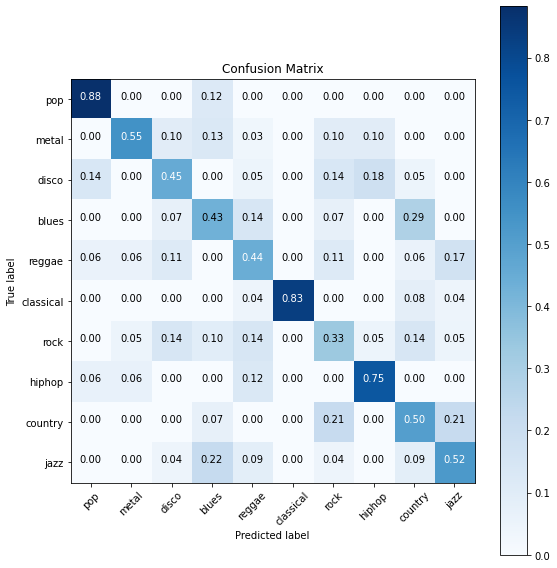


Classifier :Decision Tree
              precision    recall  f1-score   support

           0       0.57      0.65      0.60        20
           1       0.54      0.65      0.59        20
           2       0.44      0.35      0.39        20
           3       0.35      0.35      0.35        20
           4       0.47      0.40      0.43        20
           5       0.80      0.80      0.80        20
           6       0.21      0.25      0.23        20
           7       0.36      0.25      0.29        20
           8       0.25      0.25      0.25        20
           9       0.45      0.50      0.48        20

    accuracy                           0.45       200
   macro avg       0.44      0.45      0.44       200
weighted avg       0.44      0.45      0.44       200

(0.44349939382867765, 0.445, 0.44144624255431364, None)
Normalized confusion matrix


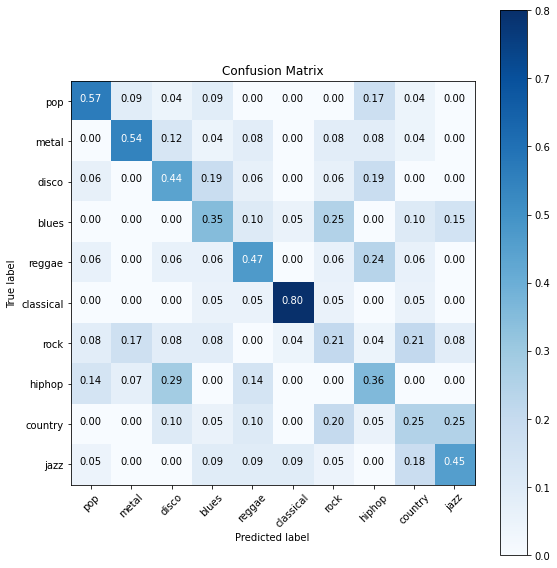


Classifier :Random Forest
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        20
           1       0.53      0.90      0.67        20
           2       0.50      0.45      0.47        20
           3       0.50      0.50      0.50        20
           4       0.75      0.45      0.56        20
           5       0.86      0.90      0.88        20
           6       0.35      0.30      0.32        20
           7       0.85      0.55      0.67        20
           8       0.47      0.40      0.43        20
           9       0.59      0.80      0.68        20

    accuracy                           0.60       200
   macro avg       0.61      0.60      0.59       200
weighted avg       0.61      0.60      0.59       200

(0.6113116186645599, 0.6, 0.5916881462007169, None)
Normalized confusion matrix


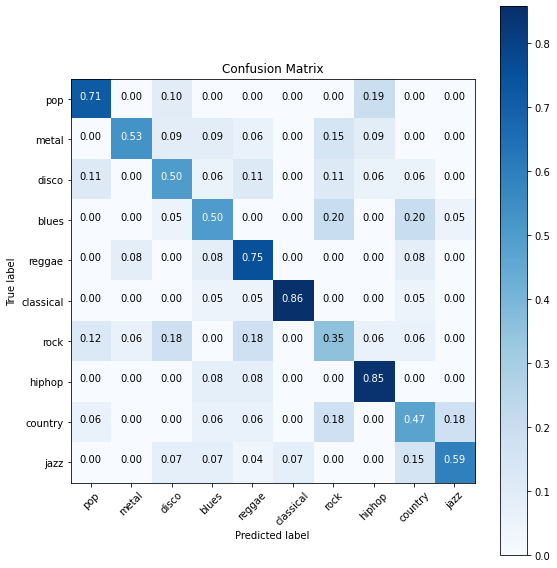


Classifier :SVM
              precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.52      0.70      0.60        20
           2       0.33      0.50      0.40        20
           3       0.40      0.30      0.34        20
           4       0.44      0.35      0.39        20
           5       0.87      1.00      0.93        20
           6       0.26      0.30      0.28        20
           7       0.69      0.55      0.61        20
           8       0.70      0.35      0.47        20
           9       0.52      0.60      0.56        20

    accuracy                           0.54       200
   macro avg       0.56      0.53      0.53       200
weighted avg       0.56      0.54      0.53       200

(0.5552555176660036, 0.5349999999999999, 0.5329467107596746, None)
Normalized confusion matrix


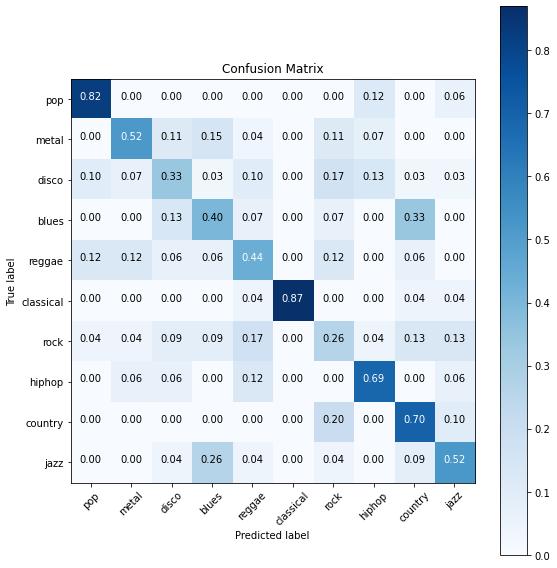


Classifier with best accuracy:Random Forest

Best accuracy:0.6


In [103]:
from collections import OrderedDict
import itertools


from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,keys, cmap=plt.cm.Blues, normalize=True, title='Confusion Matrix'):
  #print(cm)
  if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
  else:
        print('Confusion matrix, without normalization')
  
  
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(len(keys))
  plt.xticks(tick_marks, keys, rotation=45)
  plt.yticks(tick_marks, keys)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


for i,model in enumerate(pipelines):
    print("\nClassifier :{}".format(pipe_dict[i]))
    
    #training_predicted = model.predict(X_train)
    predicted = model.predict(X_test)
    true = y_test
    #print(true.shape)
    #print(predicted.shape)
    
    
    print(classification_report(true, predicted))
    print(precision_recall_fscore_support(true, predicted, average='macro'))  # print out accurate macro score
    cm = confusion_matrix(predicted, true)


    genres = {'pop': 0,
     'metal': 1,
     'disco': 2,
     'blues': 3,
     'reggae': 4,
     'classical': 5,
     'rock': 6,
     'hiphop': 7,
     'country': 8,
     'jazz': 9}

    keys=OrderedDict(sorted(genres.items(),key=lambda t:t[1])).keys()
    #print(keys.shape)

    plt.figure(figsize=(8,8))
    plot_confusion_matrix(cm,keys,normalize=True)
    plt.show()
    
    if model.score(X_test,y_test)>best_accuracy:
        best_accuracy = model.score(X_test,y_test)
        best_pipeline = model
        best_classifier = i
print("\nClassifier with best accuracy:{}".format(pipe_dict[best_classifier]))
print("\nBest accuracy:{}".format(best_accuracy))